In [268]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import random

# importing sklearn libraries
from sklearn import neural_network, linear_model, preprocessing, svm, tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

# importing keras libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import warnings

# supressing the warning on the usage of Linear Regression model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
%matplotlib inline
pd.set_option("display.max_rows", 1000)    #設定最大能顯示1000rows
pd.set_option("display.max_columns", 1000) #設定最大能顯示1000columns
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# 指定默認字形：解決plot不能顯示中文問題
mpl.rcParams['axes.unicode_minus'] = False

In [269]:
forest_fires = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv")
forest_fires.head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0


Attribute Information:

For more information, read [Cortez and Morais, 2007].
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84
(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).

The descriptions given for FFMC, DMC, DC and ISI are not very informative, a quick google search finds the following URL: http://cwfis.cfs.nrcan.gc.ca/background/summary/fwi giving the following information:

Fine Fuel Moisture Code The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel.

Duff Moisture Code The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material.

Drought Code The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs.

Initial Spread Index The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It combines the effects of wind and the FFMC on rate of spread without the influence of variable quantities of fuel.

Are there any missing values in this data set?

In [270]:
forest_fires.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
forest_fires.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

In [271]:
forest_fires.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,4.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,1.000000,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,9.000000,6.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


#### If fire area > 0, set the value to 1 and change column name from area to label so that we can see it as a classification problem

In [272]:
forest_fires['area'].values[forest_fires['area'].values > 0] = 1
forest_fires = forest_fires.rename(columns={'area': 'label'})
forest_fires

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,label
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,8,7,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
6,8,6,8,1,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
7,8,6,8,1,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0
8,8,6,9,2,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0
9,7,5,9,6,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0


In [273]:
forest_fires.corr()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,label
X,1.000000,0.539548,-0.065003,-0.024922,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.062491
Y,0.539548,1.000000,-0.066292,-0.005453,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.056892
month,-0.065003,-0.066292,1.000000,-0.050837,0.291477,0.466645,0.868698,0.186597,0.368842,-0.095280,-0.086368,0.013438,0.130329
day,-0.024922,-0.005453,-0.050837,1.000000,-0.041068,0.062870,0.000105,0.032909,0.052190,0.092151,0.032478,-0.048340,-0.042970
FFMC,-0.021039,-0.046308,0.291477,-0.041068,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.073823
DMC,-0.048384,0.007782,0.466645,0.062870,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.062672
DC,-0.085916,-0.101178,0.868698,0.000105,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.096724
ISI,0.006210,-0.024488,0.186597,0.032909,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.035663
temp,-0.051258,-0.024103,0.368842,0.052190,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.076047
RH,0.085223,0.062221,-0.095280,0.092151,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.035587


### We can find the third highest correlation coefficients would be "month", "DC", "temp"

In [274]:
forest_fires.corr()['label'].sort_values(ascending=False)

label    1.000000
month    0.130329
DC       0.096724
temp     0.076047
FFMC     0.073823
DMC      0.062672
X        0.062491
Y        0.056892
wind     0.055702
ISI      0.035663
rain     0.025550
RH      -0.035587
day     -0.042970
Name: label, dtype: float64

# Machine Learning

### Logistic Regression Classification

In [275]:
# Logistic Regression Classification
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaler.fit(forest_fires.drop('label',axis=1))
scaled_features = scaler.transform(forest_fires.drop('label',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=forest_fires.columns[:-1])
df_feat.head()

X = df_feat
y = forest_fires['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train,y_train)

predictions = logmodel.predict(X_test)

from sklearn import metrics
logmodel.score(X_train,y_train)
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))

#使用混淆矩陣
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

Accuracy: 0.48717948717948717
Precision: 0.5393258426966292
Recall: 0.5517241379310345
[[28 41]
 [39 48]]
              precision    recall  f1-score   support

         0.0       0.42      0.41      0.41        69
         1.0       0.54      0.55      0.55        87

    accuracy                           0.49       156
   macro avg       0.48      0.48      0.48       156
weighted avg       0.49      0.49      0.49       156



In [298]:
classes={0:'safe',1:'On Fire'}
x_new=[[1, 4, 9 ,1 ,91.5, 130.1, 807.1, 7.5, 21.3, 35, 2.2, 0]]
y_predict=logmodel.predict(x_new)
print(classes[y_predict[0]])

safe


# K-Nearest

In [277]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(forest_fires.drop('label',axis=1))
scaled_features = scaler.transform(forest_fires.drop('label',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=forest_fires.columns[:-1])
df_feat.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,1.008313,0.569860,-1.968443,0.357721,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268
1,1.008313,-0.244001,1.110120,-1.090909,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268
2,1.008313,-0.244001,1.110120,0.840597,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268
3,1.440925,1.383722,-1.968443,0.357721,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155
4,1.440925,1.383722,-1.968443,1.323474,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268


In [278]:
from sklearn.model_selection import train_test_split
X = df_feat
y = forest_fires['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

In [279]:
from sklearn.neighbors import KNeighborsClassifier
#從k值=1開始測試
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

Text(0, 0.5, 'Error Rate')

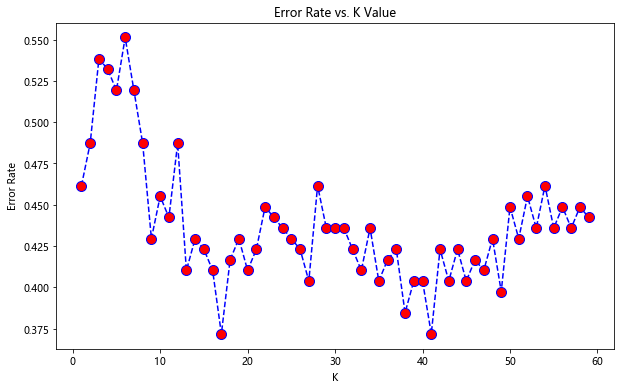

In [280]:
error_rate = []

for i in range(1,60):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))


#將k=1~60的錯誤率製圖畫出。k=7之後，錯誤率就往上跑，
plt.figure(figsize=(10,6))
plt.plot(range(1,60),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [325]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print('WITH K=7')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=7


[[36 33]
 [37 50]]


              precision    recall  f1-score   support

         0.0       0.49      0.52      0.51        69
         1.0       0.60      0.57      0.59        87

    accuracy                           0.55       156
   macro avg       0.55      0.55      0.55       156
weighted avg       0.55      0.55      0.55       156



In [281]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print('WITH K=17')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=17


[[37 32]
 [26 61]]


              precision    recall  f1-score   support

         0.0       0.59      0.54      0.56        69
         1.0       0.66      0.70      0.68        87

    accuracy                           0.63       156
   macro avg       0.62      0.62      0.62       156
weighted avg       0.63      0.63      0.63       156



In [282]:
knn.score(X_test, y_test)

0.6282051282051282

In [283]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))

Accuracy: 0.6282051282051282
Precision: 0.6559139784946236
Recall: 0.7011494252873564


In [297]:
classes={0:'safe',1:'On Fire'}
x_new=[[1, 4, 9 ,1 ,91.5, 130.1, 807.1, 7.5, 21.3, 35, 2.2, 0]]
y_predict=knn.predict(x_new)
print(classes[y_predict[0]])

On Fire


# SVM

In [296]:
# Support Vector Machine
from sklearn import metrics
from sklearn.svm import SVC
# fit a SVM model to the data

X = forest_fires.drop('label', axis=1)
y = forest_fires['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101)

svc = SVC()
svc.fit(X_train, y_train)
# make predictions
prediction = svc.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

print("Accuracy:",metrics.accuracy_score(y_test, prediction))
print("Precision:",metrics.precision_score(y_test, prediction))
print("Recall:",metrics.recall_score(y_test, prediction))

classes={0:'safe',1:'On Fire'}
x_new=[[1, 4, 9 ,1 ,91.5, 130.1, 807.1, 7.5, 21.3, 35, 2.2, 0]]
y_predict=svc.predict(x_new)
print(classes[y_predict[0]])

              precision    recall  f1-score   support

         0.0       0.65      0.29      0.40        69
         1.0       0.61      0.87      0.72        87

    accuracy                           0.62       156
   macro avg       0.63      0.58      0.56       156
weighted avg       0.62      0.62      0.58       156

[[20 49]
 [11 76]]
Accuracy: 0.6153846153846154
Precision: 0.608
Recall: 0.8735632183908046
On Fire


# Decision Tree

In [295]:
# Decision Tree Classifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

X = forest_fires.drop('label', axis=1)
y = forest_fires['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101)

d_tree = DecisionTreeClassifier()
d_tree.fit(X_train, y_train)

# make predictions
predicted = d_tree.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

print("Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print("Recall:",metrics.recall_score(y_test, predicted))

classes={0:'safe',1:'On Fire'}
x_new=[[1, 4, 9 ,1 ,91.5, 130.1, 807.1, 7.5, 21.3, 35, 2.2, 0]]
y_predict=d_tree.predict(x_new)
print(classes[y_predict[0]])

              precision    recall  f1-score   support

         0.0       0.49      0.48      0.48        69
         1.0       0.59      0.60      0.59        87

    accuracy                           0.54       156
   macro avg       0.54      0.54      0.54       156
weighted avg       0.54      0.54      0.54       156

[[33 36]
 [35 52]]
Accuracy: 0.5448717948717948
Precision: 0.5909090909090909
Recall: 0.5977011494252874
On Fire


In [294]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
X = forest_fires.drop('label', axis=1)
y = forest_fires['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101)

# fit a k-nearest neighbor model to the data
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print(knn)
# make predictions
predicted = knn.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

print("Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print("Recall:",metrics.recall_score(y_test, predicted))

classes={0:'safe',1:'On Fire'}
x_new=[[1, 4, 9 ,1 ,91.5, 130.1, 807.1, 7.5, 21.3, 35, 2.2, 0]]
y_predict=knn.predict(x_new)
print(classes[y_predict[0]])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

         0.0       0.54      0.54      0.54        69
         1.0       0.63      0.63      0.63        87

    accuracy                           0.59       156
   macro avg       0.58      0.58      0.58       156
weighted avg       0.59      0.59      0.59       156

[[37 32]
 [32 55]]
Accuracy: 0.5897435897435898
Precision: 0.632183908045977
Recall: 0.632183908045977
On Fire


In [299]:
# Gaussian Naive Bayes
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

X = forest_fires.drop('label', axis=1)
y = forest_fires['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101)

# fit a Naive Bayes model to the data
G_NB = GaussianNB()
G_NB.fit(X_train,y_train)
print(G_NB)
# make predictions

predict = G_NB.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predict))
print(metrics.confusion_matrix(y_test, predict))

print("Accuracy:",metrics.accuracy_score(y_test, predict))
print("Precision:",metrics.precision_score(y_test, predict))
print("Recall:",metrics.recall_score(y_test, predict))

classes={0:'safe',1:'On Fire'}
x_new=[[1, 4, 9 ,1 ,91.5, 130.1, 807.1, 7.5, 21.3, 35, 2.2, 0]]
y_predict=G_NB.predict(x_new)
print(classes[y_predict[0]])

GaussianNB(priors=None, var_smoothing=1e-09)
              precision    recall  f1-score   support

         0.0       0.45      0.80      0.58        69
         1.0       0.59      0.23      0.33        87

    accuracy                           0.48       156
   macro avg       0.52      0.51      0.45       156
weighted avg       0.53      0.48      0.44       156

[[55 14]
 [67 20]]
Accuracy: 0.4807692307692308
Precision: 0.5882352941176471
Recall: 0.22988505747126436
On Fire


In [326]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# load dataset
X = forest_fires.drop('label', axis=1)
y = forest_fires['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101)

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(max_iter=5000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('MLP', MLPClassifier()))
models.append(('GradientBoost',GradientBoostingClassifier()))
models.append(('AdaBoost',AdaBoostClassifier()))
models.append(('Bagging',BaggingClassifier()))
models.append(('RandomForest',RandomForestClassifier()))
models.append(('ExtraTrees',ExtraTreesClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=100)
    cv_results = model_selection.cross_val_score(model, X, Y,   cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.495667 (0.233935)
KNN: 0.540667 (0.239703)
CART: 0.531667 (0.218244)
NB: 0.505333 (0.296038)
SVM: 0.570000 (0.287769)
MLP: 0.535333 (0.291503)
GradientBoost: 0.532000 (0.249084)
AdaBoost: 0.543000 (0.218545)
Bagging: 0.501000 (0.281798)
RandomForest: 0.540000 (0.247925)
ExtraTrees: 0.518000 (0.236710)


In [ ]:
|